# Download Daymet datasets for a Polygonal Area

This tutorial will demonstrate how to download [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) for a polygonal area. Daymet dataset is available for North America (NA), including Hawaii (HI) and Puerto Rico (PR). 

## Polygonal Area
We will use a boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. Let's read the boundary file first.

In [1]:
import geopandas as gpd
grsm_poly = gpd.read_file('GRSM/GRSM_BOUNDARY_POLYGON_fid17.shp')
grsm_poly.crs

<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 84°W to 78°W and NAD83 by country
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we see above, the boundary file is in the `UTM 17N` projection. Daymet is natively in `lambert_conformal_conic (LCC)` system. We can now reproject the geopandas object (`grsm_poly`) to LCC.

In [2]:
#defining Daymet proj
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
grsm_poly_lcc = grsm_poly.to_crs(daymet_proj)
grsm_poly_lcc.crs

<Projected CRS: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.31424 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now, let's get a bounding box of this polygon and plot its boundary.

In [3]:
bounds = grsm_poly_lcc.bounds
bounds

,minx,miny,maxx,maxy
0,1.386957e+06,-612937.065386,1.470587e+06,-565105.068335


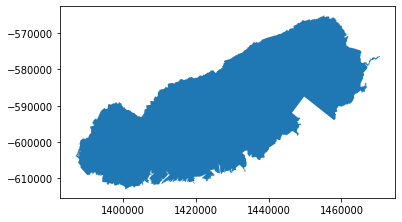

In [4]:
ax= grsm_poly_lcc.plot()

## Searching for Daymet Files
Daymet data files (or granules) are natively in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for US, PR, HI). We will first search for all the granules in the area of interest (i.e., GRSM) and the time period.  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as `*_pr_*.nc` and (`*_hi_*.nc`) respectively. For this tutorial, we will download precipitation data (`prcp`) for the year 2010-2020.

In [5]:
import datetime as dt 

dt_format = '%Y-%m-%dT%H:%M:%SZ'
start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 1, 1)  # specify your end start date
var = 'prcp' # select your own variable

Daymet data is now archived at [NASA's EarthData Cloud](https://earthdata.nasa.gov/esds/cloud). Daymet data should be cited as: `Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1840`.

The last part of the above citation is the Digital Object Identifier or [DOI](https://www.doi.org/). We can use the DOI to obtain NASA EarthData's unique ID for this dataset (called `Concept ID`). We will use NASA's [CMR API](https://cmr.earthdata.nasa.gov/search) for this purpose.

In [6]:
import requests
daymet_doi = '10.3334/ORNLDAAC/1840'
cmrurl='https://cmr.earthdata.nasa.gov/search/' # CMR API base url
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
concept_id = collection['id']
print(concept_id)

C2031536952-ORNL_CLOUD


`C2031536952-ORNL_CLOUD` is the unique NASA-given concept ID for the Daymet dataset. We can use this to get relevant granules and their names. 

In [7]:
# bound of polygon in lat, lng
xy = grsm_poly.crs.area_of_use.bounds
xy

(-84.0, 23.81, -78.0, 84.0)

In [8]:
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy))
                
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']
granule_names = []
for g in granules:
    granule_name = g['title']
    if "prcp_" in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_Daily_V4.daymet_v4_daily_na_prcp_2010.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2011.nc


Now the array `granule_names` contains the names of all the granules we need. 

## Downloading subset data through THREDDS
Daymet data is available through ORNL DAAC's THREDDS server. We will use this to download the polygonal subset.

In [9]:
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr

username = "XXXX" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "XXXX"

thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/'
# hyrax_url = 'http://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=thredds_url)

cnt = 0 
for g_name in granule_names:
    
    granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4.','')
    #     granule_dap = hyrax_url + g_name
    
    thredds_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
    
    dummy=ds['prcp'].sel(x=slice(bounds.minx[0],bounds.maxx[0]), y=slice(bounds.maxy[0],bounds.miny[0]))
    
    if cnt==0:
        prcp = dummy
    else:
        prcp = xr.concat([prcp, dummy], dim="time")
    
    cnt += 1
    print(granule_dap)

# save to netcdf
prcp.to_netcdf(var + '_subset.nc')

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2010.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2011.nc


Now, the `prcp` contains subset data for the bounding box of our area. Let's plot a day of the data. 

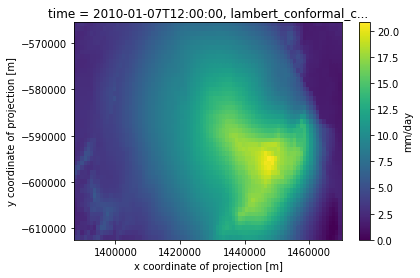

In [10]:
import matplotlib.pyplot as plt
prcp_grsm = prcp.isel(time=6)
ax = plt.subplot()
prcp_grsm.plot(ax=ax, cbar_kwargs={'label': 'mm/day'})

## Clipping the subset area by polygon

First, we will define an affine transformation.

In [11]:
from rasterio.transform import Affine
res =1000 # daymet resolution
transform = Affine.translation(min(prcp.x).values - res / 2, min(prcp.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, 1387250.0,
       0.0, 1000.0, -612500.0)

In [12]:
from rasterio.features import geometry_mask
grsm_mask = geometry_mask(grsm_poly_lcc.geometry, out_shape=(len(prcp.y), len(prcp.x)), transform=transform, invert=True)
polymask = xr.DataArray(grsm_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
prcp_masked = prcp.where(polymask == True)
prcp_masked.to_netcdf(var + '_subset_poly.nc')

Now let's plot the subset data for a day.

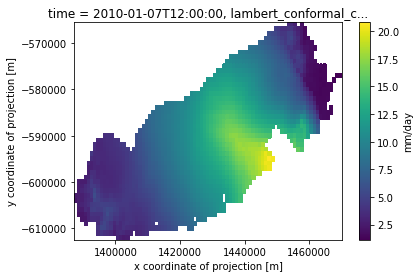

In [13]:
import matplotlib.pyplot as plt
prcp_1 = prcp_masked.isel(time=6)
ax = plt.subplot()
prcp_1.plot(ax=ax, cbar_kwargs={'label': 'mm/day'})

## Saving the subset polygon to GeoTiff
The subset data can also be clipped by a polygon of interest and converted to GeoTiff using the `rioxarray` module. 

In [14]:
import rioxarray
from shapely.geometry import mapping
prcp_sub = rioxarray.open_rasterio(var + '_subset.nc', decode_coords="all")
prcp_clip = prcp_sub.prcp.rio.clip(grsm_poly_lcc.geometry.apply(mapping), grsm_poly_lcc.crs, invert=False, from_disk=True)

# saving one time step to geotiff
prcp_clip_day6 = prcp_clip.isel(time=6)
prcp_clip_day6.rio.to_raster("prcp_clip_day6.tif")